In [61]:
%pip install scikit-learn -q
%pip install pandas -q
%pip install numpy -q
%pip install matplotlib -q
%pip install seaborn -q
%pip install keras -q
%pip install os -q

%pip install cvxopt -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


Note: you may need to restart the kernel to use updated packages.


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from sklearn import preprocessing, model_selection
import random
import seaborn as sns
import os
import cvxEDA

In [63]:
MAIN_PATH = os.path.dirname(os.getcwd())
DATA_PATH = MAIN_PATH + "/data/"

QUALITY_THRESHOLD = 64
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1024
NUM_FOLDS = 10

**Choice options of metrics are as follows:**
- w_eda
- cvx_phasic
- cvx_tonic

In [64]:
METRIC = "w_eda"

**MODEL CONFIGURATION**

- adjust if necessary. This defines the model's performance

In [65]:
dataset = pd.read_csv(DATA_PATH + "/merged_data.csv")

# IMPORTANT : UNCOMMIT THE FOLLOWING LINE WHEN CONVERTING TO PYTHON FILE. GITHUB ACTIONS ONLY ACCEPT RELATIVE PATHS!
# dataset = pd.read_csv("data/merged_data.csv")

In [66]:
import cvxEDA.src.cvxEDA

def calculate_eda_levels(y):
    fs_dict = {'ACC': 32, 'BVP': 64, 'EDA': 4, 'TEMP': 4, 'label': 700, 'Resp': 700}
    Fs = fs_dict['EDA']
    yn = (y - y.mean()) / y.std()
    [r, p, t, l, d, e, obj] = cvxEDA.src.cvxEDA.cvxEDA(yn, 1. / Fs)
    return r, t, yn


In [67]:
import matplotlib.pyplot as plt

# Define unique_ids
unique_ids = dataset['ID'].unique()

# Initialize the new DataFrame
new_dataframe_eda = pd.DataFrame(columns=["cvx_phasic", "cvx_tonic"])

# Iterate through each unique id
for unique_id in unique_ids:
    # Filter data for each id
    subset_data = dataset[dataset['ID'] == unique_id]
    
    # Calculate EDA levels
    phasic, tonic, yn = calculate_eda_levels(subset_data['w_eda'].values)
    
    # Create a temporary DataFrame to hold the new data
    temp_df = pd.DataFrame({
        "cvx_phasic": phasic, 
        "cvx_tonic": tonic
    })

    new_dataframe_eda = pd.concat([new_dataframe_eda, temp_df], ignore_index=True)

     pcost       dcost       gap    pres   dres
 0: -1.2092e+04 -1.2037e+04  5e+04  2e+02  2e-01
 1: -1.2089e+04 -2.0310e+04  1e+04  4e+01  5e-02
 2: -1.2096e+04 -1.5177e+04  3e+03  1e+01  1e-02
 3: -1.2097e+04 -1.3431e+04  1e+03  4e+00  4e-03
 4: -1.2096e+04 -1.2680e+04  6e+02  1e+00  2e-03
 5: -1.2091e+04 -1.2408e+04  3e+02  5e-01  6e-04
 6: -1.2091e+04 -1.2262e+04  2e+02  2e-01  3e-04
 7: -1.2109e+04 -1.2156e+04  5e+01  3e-02  4e-05
 8: -1.2129e+04 -1.2144e+04  1e+01  9e-03  1e-05
 9: -1.2136e+04 -1.2142e+04  6e+00  3e-03  3e-06
10: -1.2139e+04 -1.2142e+04  3e+00  8e-04  1e-06
11: -1.2140e+04 -1.2141e+04  1e+00  2e-04  2e-07
12: -1.2141e+04 -1.2141e+04  4e-01  4e-05  5e-08
13: -1.2141e+04 -1.2141e+04  1e-01  8e-06  1e-08
14: -1.2141e+04 -1.2141e+04  3e-02  5e-07  6e-10
15: -1.2141e+04 -1.2141e+04  9e-03  5e-08  7e-11
16: -1.2141e+04 -1.2141e+04  3e-03  1e-08  1e-11
17: -1.2141e+04 -1.2141e+04  7e-04  2e-09  2e-12
18: -1.2141e+04 -1.2141e+04  1e-04  2e-10  2e-13
19: -1.2141e+04 -1.21

C:\Users\goert\AppData\Local\Temp\ipykernel_25944\743300855.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_dataframe_eda = pd.concat([new_dataframe_eda, temp_df], ignore_index=True)


     pcost       dcost       gap    pres   dres
 0: -1.2965e+04 -1.2924e+04  5e+04  2e+02  1e-01
 1: -1.2950e+04 -1.7515e+04  5e+03  2e+01  2e-02
 2: -1.2952e+04 -1.3636e+04  7e+02  3e+00  2e-03
 3: -1.2950e+04 -1.3146e+04  2e+02  7e-01  4e-04
 4: -1.2956e+04 -1.3006e+04  5e+01  1e-01  7e-05
 5: -1.2973e+04 -1.2984e+04  1e+01  1e-02  8e-06
 6: -1.2978e+04 -1.2983e+04  5e+00  3e-03  2e-06
 7: -1.2981e+04 -1.2983e+04  2e+00  1e-03  7e-07
 8: -1.2982e+04 -1.2983e+04  8e-01  3e-04  2e-07
 9: -1.2983e+04 -1.2983e+04  3e-01  7e-05  5e-08
10: -1.2983e+04 -1.2983e+04  1e-01  2e-05  1e-08
11: -1.2983e+04 -1.2983e+04  4e-02  4e-06  3e-09
12: -1.2983e+04 -1.2983e+04  1e-02  7e-07  5e-10
13: -1.2983e+04 -1.2983e+04  3e-03  1e-07  9e-11
14: -1.2983e+04 -1.2983e+04  9e-04  2e-08  1e-11
15: -1.2983e+04 -1.2983e+04  3e-04  3e-09  2e-12
16: -1.2983e+04 -1.2983e+04  6e-05  2e-10  2e-13
17: -1.2983e+04 -1.2983e+04  1e-05  2e-11  2e-14
18: -1.2983e+04 -1.2983e+04  2e-06  2e-12  8e-15
Optimal solution foun

In [68]:
dataset = pd.concat([dataset, new_dataframe_eda], axis=1)

In [69]:
import pandas as pd

# Function to create sequences DataFrame
def create_sequences_df(merged_df, max_length=32):
    sequences = []
    temp_sequence = []
    eda_sequence = []
    label = None
    time_sequence = []
    current_id = None
    phasic_eda_sequence = []
    tonic_eda_sequence = []

    for index, row in merged_df.iterrows():
        if current_id != row['ID']:
            # New ID encountered, append previous sequence to list
            if temp_sequence:
                sequences.append({
                    'ID': current_id,
                    'w_eda': eda_sequence,
                    'w_temp': temp_sequence,
                    'downsampled_label': label,
                    'Time': time_sequence,
                    'cvx_phasic': phasic_eda_sequence,
                    'cvx_tonic': tonic_eda_sequence
                })
            # Reset sequences for new ID
            temp_sequence = [row['w_temp']]
            eda_sequence = [row['w_eda']]
            label = row['downsampled_labels']
            time_sequence = [row['Time']]
            current_id = row['ID']
            phasic_eda_sequence = [row['cvx_phasic']]
            tonic_eda_sequence = [row['cvx_tonic']]
        else:
            # Append values to sequences
            temp_sequence.append(row['w_temp'])
            eda_sequence.append(row['w_eda'])
            time_sequence.append(row['Time'])
            phasic_eda_sequence.append(row['cvx_phasic'])
            tonic_eda_sequence.append(row['cvx_tonic'])

        # Check if sequence length exceeds max_length
        if len(temp_sequence) >= max_length:
            sequences.append({
                'ID': current_id,
                'w_eda': eda_sequence,
                'w_temp': temp_sequence,
                'downsampled_label': label,
                'Time': time_sequence,
                'cvx_phasic': phasic_eda_sequence,
                'cvx_tonic': tonic_eda_sequence
            })
            # Reset sequences for new ID
            temp_sequence = []
            eda_sequence = []
            label = None
            time_sequence = []
            current_id = None
            phasic_eda_sequence = []
            tonic_eda_sequence = []

    # Append last sequence if it's not empty
    if temp_sequence:
        sequences.append({
            'ID': current_id,
            'w_eda': eda_sequence,
            'w_temp': temp_sequence,
            'downsampled_label': label,
            'Time': time_sequence,
            'cvx_phasic': phasic_eda_sequence,
            'cvx_tonic': tonic_eda_sequence
        })

    # Convert list of dictionaries to DataFrame
    sequences_df = pd.DataFrame(sequences)
    return sequences_df

# Create sequences DataFrame
sequences_df = create_sequences_df(dataset)

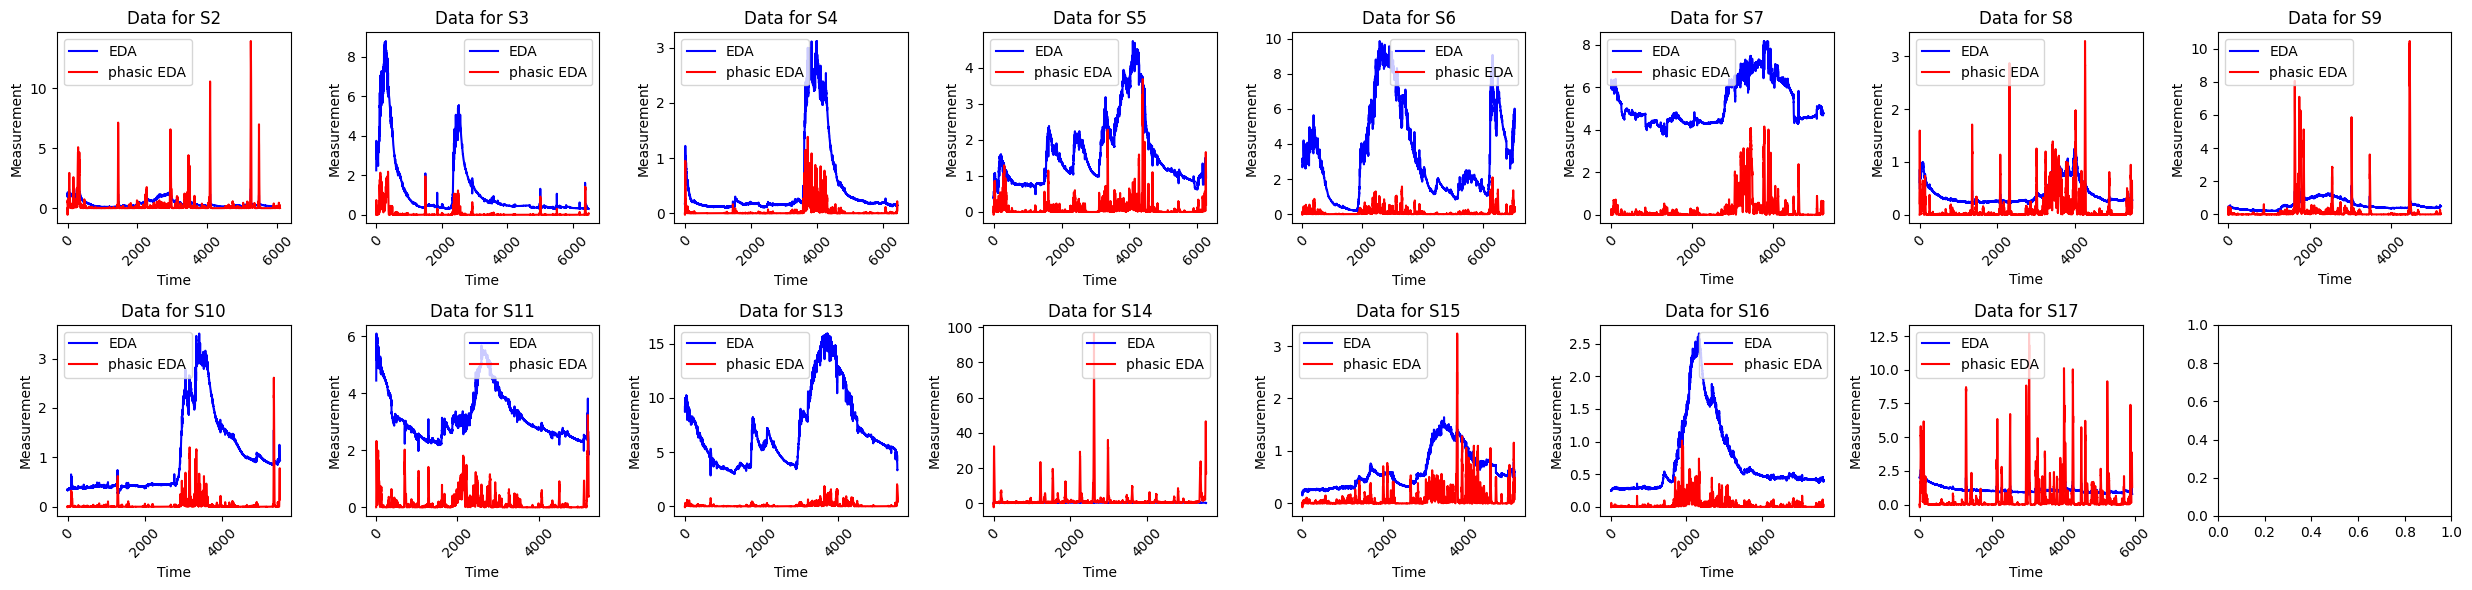

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(2, 8, figsize=(25, 6))  # Increased figure size
axes = axes.flatten()

# Define unique_ids
unique_ids = dataset['ID'].unique()

# Iterate through each unique id
for i, unique_id in enumerate(unique_ids):
    if i < len(unique_ids):
        # Filter data for each id
        subset_data = dataset[dataset['ID'] == unique_id]
        
        # Plotting
        sns.lineplot(x='Time', y='w_eda', data=subset_data, ax=axes[i], color='blue', label='EDA')
        sns.lineplot(x='Time', y='cvx_phasic', data=subset_data, ax=axes[i], color='red', label='phasic EDA')
        # sns.lineplot(x='Time', y='cvx_tonic', data=subset_data, ax=axes[i], color='yellow', label='tonic EDA')                  
        # sns.lineplot(x='Time', y='w_temp', data=subset_data, ax=axes[i], color='red', label='Temp')

        axes[i].set_title(f"Data for {unique_id}")
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Measurement')
        axes[i].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

In [71]:
sequences_df

,ID,w_eda,w_temp,downsampled_label,Time,cvx_phasic,cvx_tonic
0,S2,"[1.138257, 1.125444, 1.011405, 1.033188, 0.935...","[35.41, 35.41, 35.41, 35.41, 35.41, 35.41, 35....",0.0,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[0.0, 0.0, -0.29028704534925953, -0.4463023106...","[2.235824015415713, 2.2410226078538633, 2.2434..."
1,S2,"[1.116375, 1.109969, 1.104843, 1.099718, 1.094...","[35.45, 35.45, 35.45, 35.45, 35.41, 35.41, 35....",0.0,"[8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 1...","[0.5369178880335287, 0.5403534726202395, 0.541...","[1.6619116206256164, 1.6417932937848856, 1.622..."
2,S2,"[1.249634, 1.261166, 1.267572, 1.270135, 1.275...","[35.45, 35.45, 35.45, 35.45, 35.43, 35.43, 35....",0.0,"[16.0, 16.25, 16.5, 16.75, 17.0, 17.25, 17.5, ...","[0.7534719745225507, 0.7671649763600733, 0.757...","[1.8486647634733069, 1.874705656805469, 1.9012..."
3,S2,"[1.299606, 1.300887, 1.300887, 1.298324, 1.299...","[35.45, 35.45, 35.45, 35.45, 35.43, 35.43, 35....",0.0,"[24.0, 24.25, 24.5, 24.75, 25.0, 25.25, 25.5, ...","[0.1489031808309924, 0.13299542956110286, 0.11...","[2.610592808693715, 2.625337313560814, 2.63934..."
4,S2,"[1.289355, 1.289355, 1.288074, 1.288074, 1.286...","[35.45, 35.45, 35.45, 35.45, 35.45, 35.45, 35....",0.0,"[32.0, 32.25, 32.5, 32.75, 33.0, 33.25, 33.5, ...","[0.05310540340836996, 0.06695184337039853, 0.0...","[2.6721126459941202, 2.6586801486398914, 2.644..."
...,...,...,...,...,...,...,...
10859,S17,"[0.922787, 0.939419, 0.945816, 0.945816, 0.944...","[31.93, 31.91, 31.91, 31.91, 31.91, 31.93, 31....",0.0,"[5880.0, 5880.25, 5880.5, 5880.75, 5881.0, 588...","[3.167426942619043, 3.1266598265997567, 3.0487...","[-3.8061206452028054, -3.6971745332197568, -3...."
10860,S17,"[0.931742, 0.929184, 0.933022, 0.929184, 0.931...","[31.95, 31.99, 31.99, 31.99, 31.99, 31.99, 31....",0.0,"[5888.0, 5888.25, 5888.5, 5888.75, 5889.0, 588...","[0.43613866472046775, 0.3890677608522584, 0.34...","[-1.0450328296645508, -0.9987983684322405, -0...."
10861,S17,"[0.922787, 0.908713, 0.917669, 0.904875, 0.906...","[32.0, 32.0, 32.0, 32.0, 32.0, 32.05, 32.05, 3...",0.0,"[5896.0, 5896.25, 5896.5, 5896.75, 5897.0, 589...","[0.6493152200506745, 0.707028391598441, 0.7508...","[-1.3152401771469509, -1.370679900656556, -1.4..."
10862,S17,"[0.803802, 0.805081, 0.806361, 0.820434, 0.849...","[32.03, 32.03, 32.03, 32.03, 32.03, 31.99, 31....",0.0,"[5904.0, 5904.25, 5904.5, 5904.75, 5905.0, 590...","[2.4548501877040403, 2.523664729077592, 2.5108...","[-3.553667364788243, -3.6199554539875294, -3.6..."


In [72]:
print("Before replacing labels")
unique_labels_before = sequences_df['downsampled_label'].unique()
print(unique_labels_before, "\n")
print("Number of unique labels before replacement:", len(unique_labels_before), "\n")


Before replacing labels
[0. 1. 2. 4. 3.] 

Number of unique labels before replacement: 5 



In [73]:
sequences_df['downsampled_label'] = sequences_df['downsampled_label'].apply(lambda x : 1 if x == 2.0 else 0)

In [74]:
from sklearn import preprocessing

print("After replacing labels")
unique_labels_after = sequences_df['downsampled_label'].unique()
print(unique_labels_after)
print("Number of unique labels after replacement:", len(unique_labels_after))

le = preprocessing.LabelEncoder()  # Generates a look-up table
le.fit(sequences_df['downsampled_label'])
sequences_df['downsampled_label'] = le.transform(sequences_df['downsampled_label'])

After replacing labels
[0 1]
Number of unique labels after replacement: 2


In [75]:
num_classes = len(sequences_df['downsampled_label'].unique())
print(num_classes)


2


In [76]:
from collections import Counter

def plot_label_distribution(df):
    # Define class labels
    sorts = {
        0: "No-stress",
        1: "Stress"
    }

    # Count occurrences of each label
    label_counts = Counter(df['downsampled_label'])

    # Extract counts for '0' and '1'
    counts = [label_counts[0], label_counts[1]]
    print("Label distribution:", counts)

    # Define bar labels
    bar_labels = [sorts[0], sorts[1]]

    # Plotting
    plt.bar(bar_labels, counts)
    plt.title("Number of samples per class")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

Label distribution: [9620, 1244]


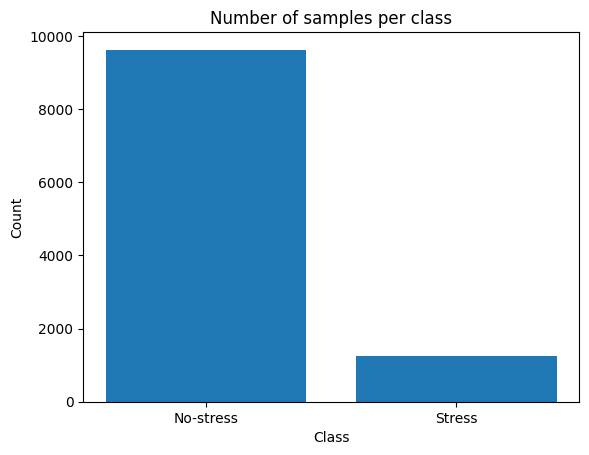

In [77]:
plot_label_distribution(sequences_df)

****Scale and split data****

We perform a simple Min-Max scaling to bring the value-range between 0 and 1.

In [78]:
# Filter out rows with ID S16 and S17
test_df = sequences_df[(sequences_df['ID'] == 'S16') | (sequences_df['ID'] == 'S17')]

# Drop the filtered rows from the original DataFrame
sequences_df = sequences_df.drop(test_df.index)

# Reset index for both DataFrames
test_df.reset_index(drop=True, inplace=True)
sequences_df.reset_index(drop=True, inplace=True)

test_subject_1 = test_df[test_df['ID'] == 'S16']
test_subject_2 = test_df[test_df['ID'] == 'S17']

In [79]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def scale_and_flatten(series_list):
    scaler = MinMaxScaler()
    return [scaler.fit_transform(np.asarray(series).reshape(-1, 1)).flatten() for series in series_list]

# Scale and flatten the 'w_eda' feature
eda_array_list = scale_and_flatten(sequences_df[METRIC])
test_array_list_subject_1 = scale_and_flatten(test_subject_1[METRIC])
test_array_list_subject_2 = scale_and_flatten(test_subject_2[METRIC])

# Extract labels and convert to numpy arrays
labels_array = np.array(sequences_df['downsampled_label'])
validation_labels_array_subject_1 = np.array(test_subject_1['downsampled_label'])
validation_labels_array_subject_2 = np.array(test_subject_2['downsampled_label'])

# Print counts
print(f"EDA list Count: {len(eda_array_list)}")
print(f"Labels list Count: {len(labels_array)}")
print(f"\nTest set 1: \nEDA list Count: {len(test_array_list_subject_1)}")
print(f"Labels list Count: {len(validation_labels_array_subject_1)}")
print(f"\nTest set 2: \nEDA list Count: {len(test_array_list_subject_2)}")
print(f"Labels list Count: {len(validation_labels_array_subject_2)}")

EDA list Count: 9420
Labels list Count: 9420

Test set 1: 
EDA list Count: 704
Labels list Count: 704

Test set 2: 
EDA list Count: 740
Labels list Count: 740


In [80]:


from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import model_selection
from collections import Counter
from imblearn.over_sampling import SMOTE
import numpy as np
import tensorflow.keras as keras

max_sequence_length = 32  # Choose the desired maximum sequence length

def pad_and_reshape(series_list, maxlen):
    padded = pad_sequences(series_list, maxlen=maxlen, dtype='float32', padding='post', truncating='post')
    reshaped = padded.reshape(-1, maxlen, 1)
    return reshaped

def apply_smote(x_train, y_train, x_val, y_val):
    x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
    x_val_reshaped = x_val.reshape(x_val.shape[0], -1)
    smote = SMOTE(random_state=42)
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train_reshaped, y_train)
    x_train_resampled = x_train_resampled.reshape(-1, x_train.shape[1], x_train.shape[2])

    x_val_resampled, y_val_resampled = smote.fit_resample(x_val_reshaped, y_val)
    x_val_resampled = x_val_resampled.reshape(-1, x_train.shape[1], x_train.shape[2])
    
    return x_train_resampled, y_train_resampled, x_val_resampled, y_val_resampled

# Padding and reshaping sequences
series_padded = pad_and_reshape(eda_array_list, max_sequence_length)
x_test_subject_1_padded = pad_and_reshape(test_array_list_subject_1, max_sequence_length)
x_test_subject_2_padded = pad_and_reshape(test_array_list_subject_2, max_sequence_length)

# Splitting data into training and testing sets (70% train, 30% validation)
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    series_padded, labels_array, test_size=0.30, random_state=42, shuffle=True
)

# Converting labels to numpy arrays
y_train = np.asarray(y_train).astype(np.float32)
y_test_subject_1 = np.asarray(validation_labels_array_subject_1).astype(np.float32)
y_test_subject_2 = np.asarray(validation_labels_array_subject_2).astype(np.float32)
y_val = np.asarray(y_val).astype(np.float32)

# Check lengths of train, validation, and test sets
print(
    f"Length of x_train : {len(x_train)}\nLength of x_test_subject_1 : {len(x_test_subject_1_padded)}\nLength of x_test_subject_2 : {len(x_test_subject_2_padded)}\nLength of x_test : {len(x_val)}\n"
    f"Length of y_train : {len(y_train)}\nLength of y_val_subject_1 : {len(y_test_subject_1)}\nLength of y_val_subject_2 : {len(y_test_subject_2)}\nLength of y_test : {len(y_val)}"
)

# Check the class distribution before SMOTE
print("Class distribution before SMOTE:", Counter(y_train))

# Apply SMOTE using the function
x_train_resampled, y_train_resampled, x_val_resampled, y_val_resampled= apply_smote(x_train, y_train, x_val, y_val)

# Check the class distribution after SMOTE
class_distribution_after = Counter(y_train_resampled)
print("Class distribution after SMOTE:", {0: class_distribution_after[0], 1: class_distribution_after[1]})



Length of x_train : 6594
Length of x_test_subject_1 : 704
Length of x_test_subject_2 : 740
Length of x_test : 2826
Length of y_train : 6594
Length of y_val_subject_1 : 704
Length of y_val_subject_2 : 740
Length of y_test : 2826
Class distribution before SMOTE: Counter({0.0: 5856, 1.0: 738})
Class distribution after SMOTE: {0: 5856, 1: 5856}


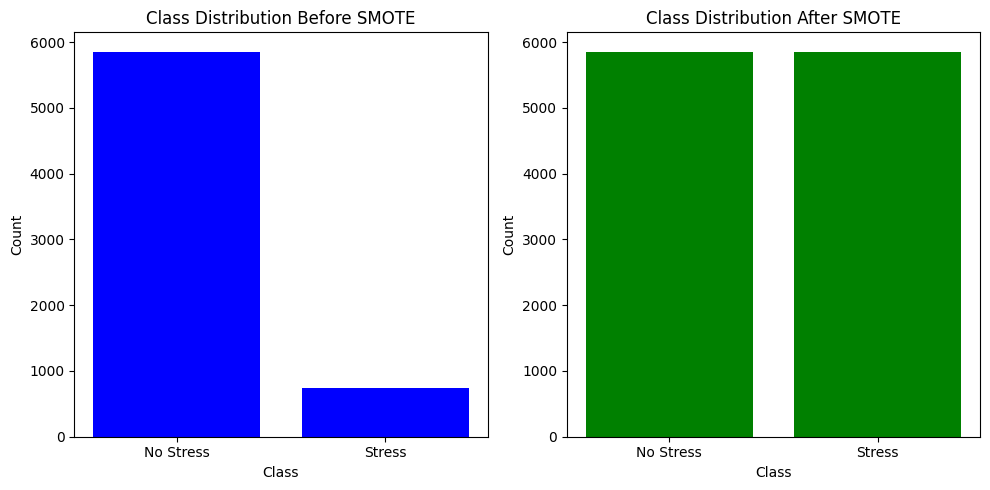

In [81]:
import matplotlib.pyplot as plt
from collections import Counter

# Class distribution before SMOTE
class_distribution_before = Counter(y_train)
# Class distribution after SMOTE
class_distribution_after = Counter(y_train_resampled)

# Define labels
labels = ['No Stress', 'Stress']

# Plotting
plt.figure(figsize=(10, 5))

# Plot before SMOTE
plt.subplot(1, 2, 1)
plt.bar(labels, class_distribution_before.values(), color='blue')
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], labels)

# Plot after SMOTE
plt.subplot(1, 2, 2)
plt.bar(labels, class_distribution_after.values(), color='green')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], labels)

plt.tight_layout()
plt.show()



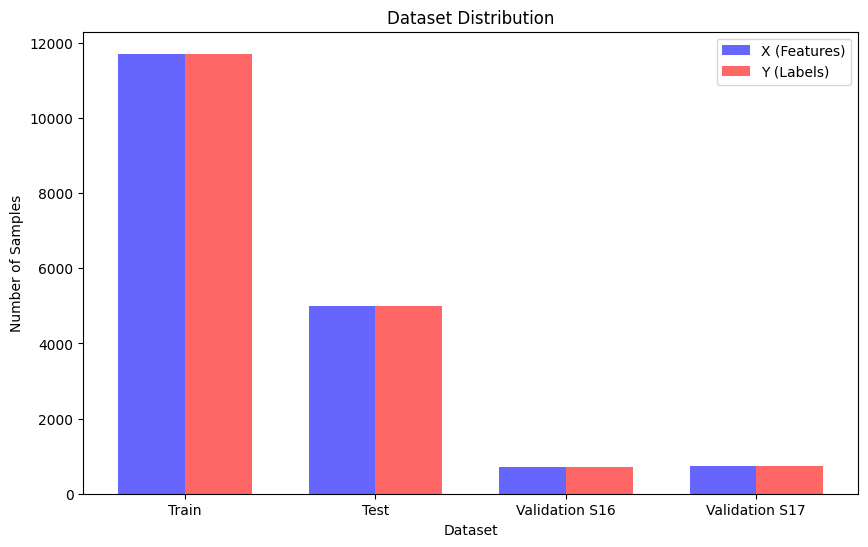

In [82]:


def plot_dataset_distribution(x_train_resampled, y_train_resampled, x_val_resampled, y_val_resampled, x_test_subject_1, y_test_subject_1, x_test_subject_2, y_test_subject_2):
    """
    Plots a bar chart showing the sizes of the train, validation, and test sets.

    Parameters:
    - x_train, y_train: Training data and labels.
    - x_test_subject_1, y_test_subject_1: Validation data and labels for subject 1.
    - x_test_subject_2, y_test_subject_2: Validation data and labels for subject 2.
    - x_val, y_val: Test data and labels.
    """
    dataset_names = ['Train', 'Test', 'Validation S16', 'Validation S17']
    x_lengths = [len(x_train_resampled), len(x_val_resampled), len(x_test_subject_1), len(x_test_subject_2)]
    y_lengths = [len(y_train_resampled), len(y_val_resampled), len(y_test_subject_1), len(y_test_subject_2)]
    
    # Plotting the bar plot
    plt.figure(figsize=(10, 6))
    
    bar_width = 0.35  # Width of the bars
    
    index = np.arange(len(dataset_names))
    
    plt.bar(index, x_lengths, bar_width, color='b', alpha=0.6, label='X (Features)')
    plt.bar(index + bar_width, y_lengths, bar_width, color='r', alpha=0.6, label='Y (Labels)')
    
    plt.xlabel('Dataset')
    plt.ylabel('Number of Samples')
    plt.title('Dataset Distribution')
    plt.xticks(index + bar_width / 2, dataset_names)
    plt.legend()
    plt.savefig("dataset_distribution.png")
    plt.show()

# Plot dataset distribution
plot_dataset_distribution(x_train_resampled, y_train_resampled, x_val_resampled, y_val_resampled, x_test_subject_1_padded, y_test_subject_1, x_test_subject_2_padded, y_test_subject_2)



In [83]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

def SplitDatasetForFolds(train_index, validation_index, fold_nr):
    print(f"Training fold {fold_nr}...")

    # Split the data into train and validation sets for this fold.
    x_train_fold = x_train_resampled[train_index]
    y_train_fold = y_train_resampled[train_index]
    x_validation_fold = x_train_resampled[validation_index]
    y_validation_fold = y_train_resampled[validation_index]

    # Create tf.data.Datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_fold, y_train_fold))
    validation_dataset = tf.data.Dataset.from_tensor_slices((x_validation_fold, y_validation_fold))
    test_dataset_subject1 = tf.data.Dataset.from_tensor_slices((x_test_subject_1_padded, y_test_subject_1))
    test_dataset_subject2 = tf.data.Dataset.from_tensor_slices((x_test_subject_2_padded, y_test_subject_2))
    

    # Shuffling and batching the datasets
    train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    validation_dataset = validation_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    test_dataset_subject1 = test_dataset_subject1.batch(BATCH_SIZE)
    test_dataset_subject2 = test_dataset_subject2.batch(BATCH_SIZE)

    return train_dataset, validation_dataset, test_dataset_subject1, test_dataset_subject2

In [84]:
vals_dict = {}
for i in sequences_df['downsampled_label']:
    if i in vals_dict.keys():
        vals_dict[i] += 1
    else:
        vals_dict[i] = 1
total = sum(vals_dict.values())

weight_dict = {k: (1 - (v / total)) for k, v in vals_dict.items()}
print(weight_dict)

{0: 0.113588110403397, 1: 0.886411889596603}


In [85]:
# Assuming your one-hot encoded labels are in a variable named 'labels'
binary_labels = np.argmax(sequences_df['downsampled_label'])
print("Shape of binary labels:", binary_labels.shape)

Shape of binary labels: ()


In [86]:
def plot_history_metrics(history_dict: dict):
    total_plots = len(history_dict)
    cols = total_plots // 2
    rows = total_plots // cols
    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history_dict.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

In [87]:
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks

def create_model():
    input_layer = keras.Input(shape=(32, 1))
    
    x = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.001))(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)
    
    output_layer = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    
    return model


In [88]:
conv_model = create_model()
conv_model.summary()

# Save model to JSON
model_json = conv_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 conv1d_21 (Conv1D)          (None, 32, 32)            128       
                                                                 
 batch_normalization_21 (Bat  (None, 32, 32)           128       
 chNormalization)                                                
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 16, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 16, 64)            6208      
                                                                 
 batch_normalization_22 (Bat  (None, 16, 64)           256 

In [89]:
# To store history of each fold
history_list = []
fold_number = 1

best_val_accuracy = 0
best_model_filename = ""


for train_index, val_index in kfold.split(x_train_resampled):
    # Split data into training and validation sets for this fold.
    train_dataset, validation_dataset, test_sj1, test_sj2 = SplitDatasetForFolds(train_index, val_index, fold_number)

    # Create a new model instance
    model = create_model()

    # Compile the model
    optimizer = keras.optimizers.Adam(amsgrad=True, learning_rate=0.001)
    loss = keras.losses.BinaryCrossentropy()
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[
            keras.metrics.BinaryAccuracy(name='binary_accuracy'),
            keras.metrics.AUC(name='auc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
        ],
    )

    # Set up callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(f"best_model_fold_{fold_number}.keras", save_best_only=True, monitor="val_binary_accuracy"),
        # keras.callbacks.Early_stopping(monitor='val_loss', patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    ]

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=30,
        validation_data=(x_val_resampled,y_val_resampled),
        callbacks=callbacks,
        class_weight=weight_dict
    )

    # Append history
    history_list.append(history.history)

        # Check if this model has the best validation accuracy so far
    if history.history['val_binary_accuracy'][-1] > best_val_accuracy:
        best_val_accuracy = history.history['val_binary_accuracy'][-1]
        best_model_filename = f"best_model_fold_{fold_number}.keras"

    fold_number += 1
    print(f"Training fold {fold_number} completed\n")
    print("------------------------------------------------------------------------------------------------------------------\n")

print("Cross-validation training completed")

Training fold 1...
Epoch 1/30
330/330 [==============================] - 12s 31ms/step - loss: 0.7700 - binary_accuracy: 0.7622 - auc: 0.9329 - precision: 0.6918 - recall: 0.9530 - val_loss: 2.3847 - val_binary_accuracy: 0.5000 - val_auc: 0.6210 - val_precision: 0.5000 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/30
330/330 [==============================] - 8s 26ms/step - loss: 0.3753 - binary_accuracy: 0.7688 - auc: 0.9412 - precision: 0.6945 - recall: 0.9669 - val_loss: 2.7495 - val_binary_accuracy: 0.5192 - val_auc: 0.7105 - val_precision: 0.5098 - val_recall: 0.9992 - lr: 0.0010
Epoch 3/30
330/330 [==============================] - 8s 25ms/step - loss: 0.2228 - binary_accuracy: 0.7678 - auc: 0.9418 - precision: 0.6918 - recall: 0.9731 - val_loss: 2.4471 - val_binary_accuracy: 0.5104 - val_auc: 0.7492 - val_precision: 0.5053 - val_recall: 0.9992 - lr: 0.0010
Epoch 4/30
330/330 [==============================] - 8s 25ms/step - loss: 0.1635 - binary_accuracy: 0.7533 - auc: 0.9425 - prec

In [90]:
# Load the best model
best_model = keras.models.load_model(best_model_filename)

# Now you have the best model, you can evaluate it on the test set
for dataset in [train_dataset, validation_dataset]:
    print("Training set" if dataset == train_dataset else "Validation set")
    loss, binary_accuracy, auc, precision, recall = best_model.evaluate(dataset)
    print(f"Loss: {loss}\n Binary Accuracy: {binary_accuracy}\n AUC: {auc}\n Precision: {precision}\n Recall: {recall}\n")

with open(f"metrics.txt", "w") as f:
    f.write(f"Loss: {loss}\n Binary Accuracy: {binary_accuracy}\n AUC: {auc}\n Precision: {precision}\n Recall: {recall}\n") 

Training set
330/330 [==============================] - 4s 10ms/step - loss: 0.5986 - binary_accuracy: 0.8611 - auc: 0.9559 - precision: 0.7828 - recall: 0.9998
Loss: 0.5985792875289917
 Binary Accuracy: 0.8611137270927429
 AUC: 0.9559412002563477
 Precision: 0.7828410267829895
 Recall: 0.9998103976249695

Validation set
37/37 [==============================] - 0s 12ms/step - loss: 0.5616 - binary_accuracy: 0.8728 - auc: 0.9579 - precision: 0.7959 - recall: 1.0000
Loss: 0.5615841150283813
 Binary Accuracy: 0.8727583289146423
 AUC: 0.9578503370285034
 Precision: 0.7958903908729553
 Recall: 1.0



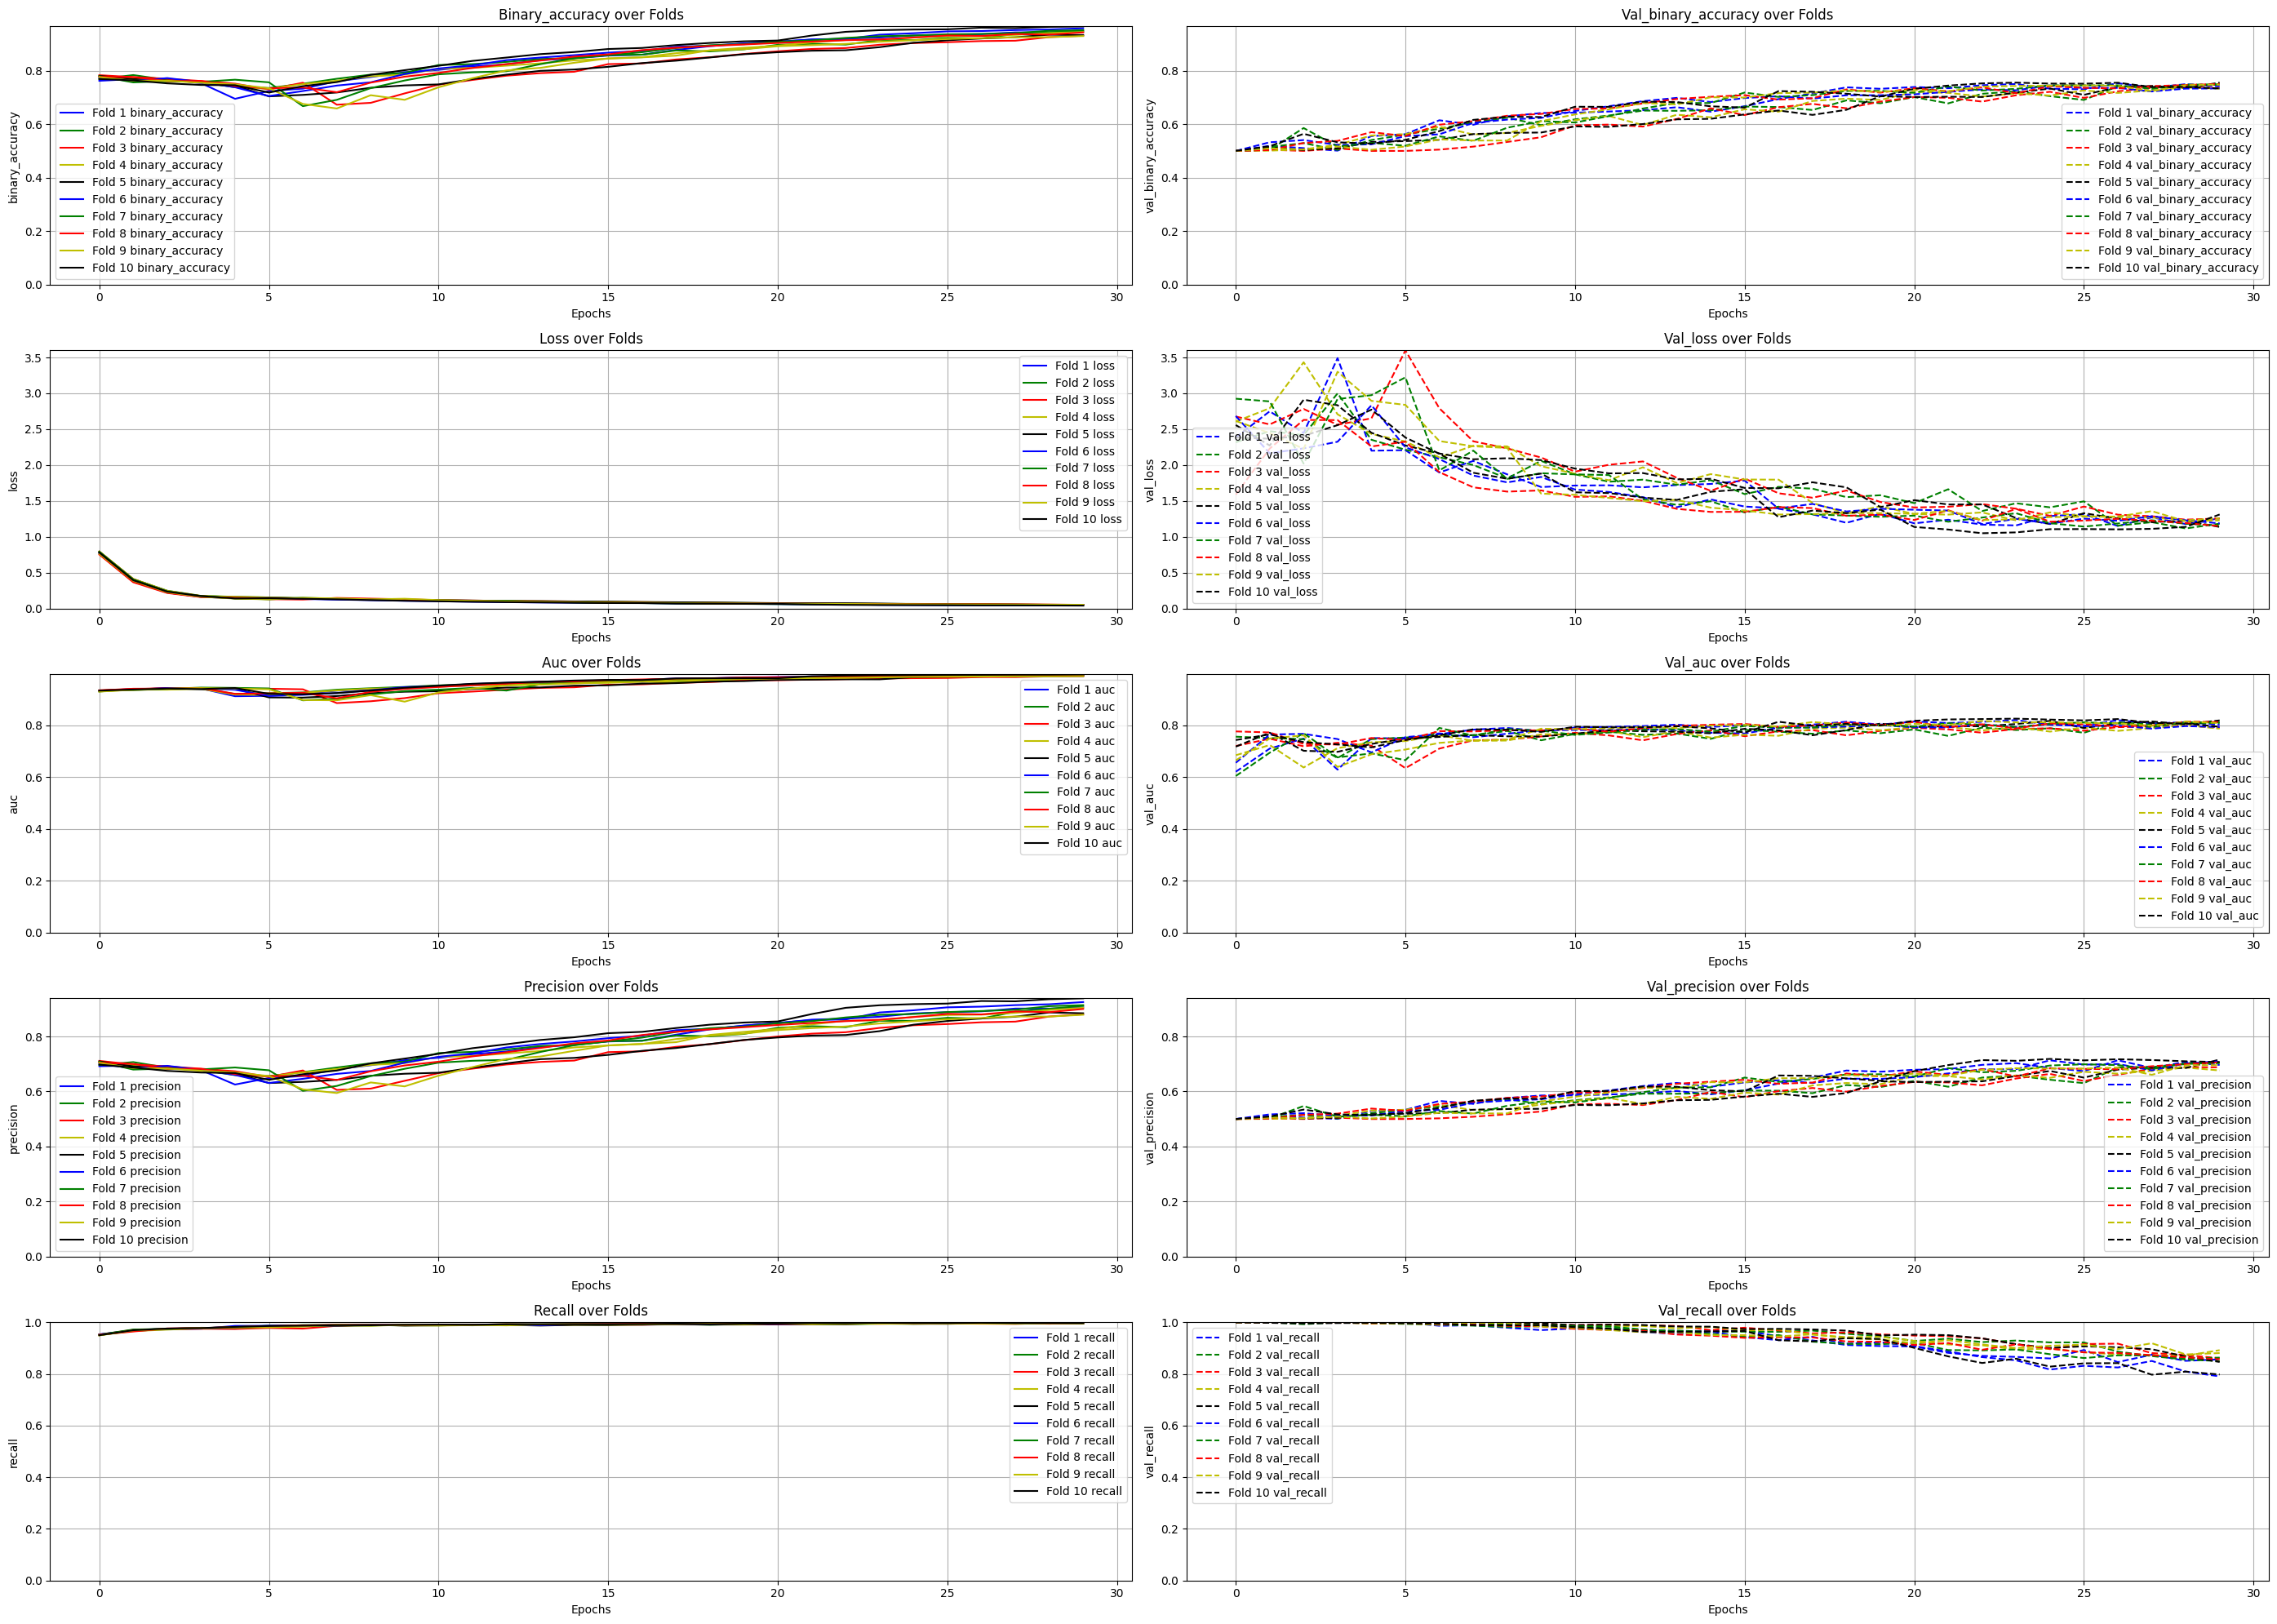

In [91]:
import matplotlib.pyplot as plt

# Define a color scheme for metrics
colors = ['b', 'g', 'r', 'y', 'k']

# Plotting the metrics for all folds
def plot_metrics(history_list, metrics, val_metrics, colors):
    num_metrics = len(metrics)
    fig, axs = plt.subplots(nrows=num_metrics, ncols=2, figsize=(28, 20))
    for i, (metric, val_metric) in enumerate(zip(metrics, val_metrics)):
        train_max = max([max(history[metric]) for history in history_list])
        val_max = max([max(history[val_metric]) for history in history_list])
        y_max = max(train_max, val_max)
        for j, history in enumerate(history_list):
            color_index = j % len(colors)  # Get color index for this fold
            color = colors[color_index]     # Get color for this fold
            axs[i, 0].plot(history[metric], label=f'Fold {j+1} {metric}', color=color)
            axs[i, 1].plot(history[val_metric], label=f'Fold {j+1} {val_metric}', linestyle='--', color=color)
        axs[i, 0].set_title(f'{metric.capitalize()} over Folds')
        axs[i, 0].set_xlabel('Epochs')
        axs[i, 0].set_ylabel(metric)
        axs[i, 0].legend()
        axs[i, 0].grid()
        axs[i, 0].set_ylim([0, y_max])  # Set y-axis limit for training plot
        
        axs[i, 1].set_title(f'{val_metric.capitalize()} over Folds')
        axs[i, 1].set_xlabel('Epochs')
        axs[i, 1].set_ylabel(val_metric)
        axs[i, 1].legend()
        axs[i, 1].grid()
        axs[i, 1].set_ylim([0, y_max])  # Set y-axis limit for validation plot
        
    plt.tight_layout()
    plt.savefig('folds.png')
    plt.show()

# Updated metrics list based on the actual keys from the history dictionary
metrics = ['binary_accuracy', 'loss', 'auc', 'precision', 'recall']
val_metrics = ['val_binary_accuracy', 'val_loss', 'val_auc', 'val_precision', 'val_recall']

# Plot metrics
plot_metrics(history_list, metrics, val_metrics, colors)


In [101]:
# Calculate mean and standard deviation for each metric
metrics_mean = {}
metrics_std = {}

for metric_name in history_list[0].keys():
    metric_values = [fold[metric_name] for fold in history_list]
    metrics_mean[metric_name] = np.mean(metric_values)
    metrics_std[metric_name] = np.std(metric_values)

# Calculate F1 score
f1_score_mean = 2 * metrics_mean['precision'] * metrics_mean['recall'] / (metrics_mean['precision'] + metrics_mean['recall'])

# Print or use the mean and standard deviation values
for metric_name in metrics_mean.keys():
    print(f"{metric_name}: Mean - {metrics_mean[metric_name]}, Std - {metrics_std[metric_name]}")

# Print or use the F1 score mean
print(f"F1 Score: Mean - {f1_score_mean}")

loss: Mean - 0.12881510155896345, Std - 0.13883601717976918
binary_accuracy: Mean - 0.8385199757417043, Std - 0.07738341482955458
auc: Mean - 0.9613502856095631, Std - 0.026537838173442182
precision: Mean - 0.7699361211061477, Std - 0.08851083791779049
recall: Mean - 0.9887978426615397, Std - 0.00986398624342214
val_loss: Mean - 1.731300038099289, Std - 0.537112333437535
val_binary_accuracy: Mean - 0.6492669067780177, Std - 0.08347949335947089
val_auc: Mean - 0.7744459704558054, Std - 0.03791703091802087
val_precision: Mean - 0.6047039331992468, Std - 0.06774220918460899
val_recall: Mean - 0.9465784559647242, Std - 0.052309759785276085
lr: Mean - 0.00029399999766610563, Std - 0.0003190046991221607
F1 Score: Mean - 0.865749102730713


In [102]:
# Load the best model
print(best_model_filename)
best_model = keras.models.load_model(best_model_filename)

# Now you have the best model, you can evaluate it on the test set
for dataset in [train_dataset, validation_dataset]:
    print("Training set" if dataset == train_dataset else "Validation set")
    loss, binary_accuracy, auc, precision, recall = best_model.evaluate(dataset)
    print(f"Loss: {loss}\n Binary Accuracy: {binary_accuracy}\n AUC: {auc}\n Precision: {precision}\n Recall: {recall}\n")


with open(f"metrics.txt", "w") as f:
    f.write(f"Loss: {loss}\n Binary Accuracy: {binary_accuracy}\n AUC: {auc}\n Precision: {precision}\n Recall: {recall}\n") 

best_model_fold_5.keras
Training set
330/330 [==============================] - 4s 10ms/step - loss: 0.5986 - binary_accuracy: 0.8611 - auc: 0.9559 - precision: 0.7828 - recall: 0.9998
Loss: 0.5985791683197021
 Binary Accuracy: 0.8611137270927429
 AUC: 0.9559412002563477
 Precision: 0.7828410267829895
 Recall: 0.9998103976249695

Validation set
37/37 [==============================] - 0s 10ms/step - loss: 0.5616 - binary_accuracy: 0.8728 - auc: 0.9579 - precision: 0.7959 - recall: 1.0000
Loss: 0.5615841150283813
 Binary Accuracy: 0.8727583289146423
 AUC: 0.9578503370285034
 Precision: 0.7958903908729553
 Recall: 1.0



Final epoch metrics for best model (Fold 5) on Validation set:
Loss: 0.05256340652704239 
Binary Accuracy: 0.9331182837486267 
AUC: 0.9909988641738892 
Precision: 0.8843434453010559 
Recall: 0.9965850710868835

Final epoch metrics for best model (Fold 5) on Validation set:
Loss: 1.1375690698623657 
Binary Accuracy: 0.7554129958152771 
AUC: 0.8194063305854797 
Precision: 0.7160786986351013 
Recall: 0.8464314341545105



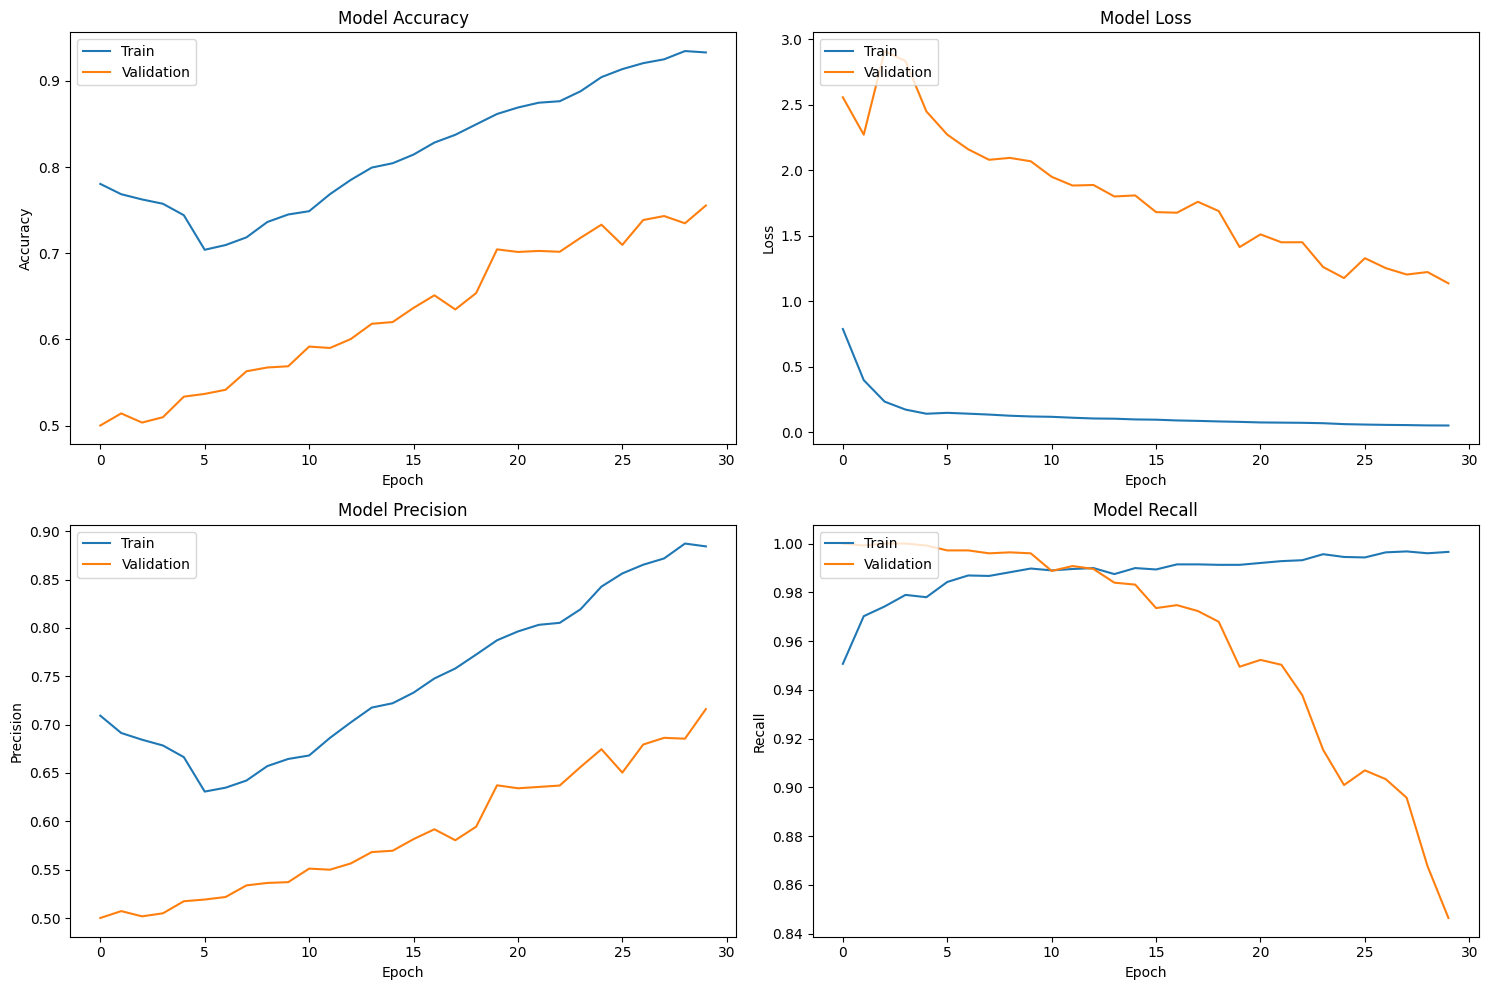

In [108]:
import matplotlib.pyplot as plt

# Identify the index of the best model from the filename
best_fold_index = int(best_model_filename.split('_')[-1].split('.')[0]) - 1

# Extract the history of the best model
best_model_history = history_list[best_fold_index]

final_epoch = len(best_model_history['loss']) - 1
print(f"Final epoch metrics for best model (Fold {best_fold_index + 1}) on Validation set:")
print(f"Loss: {best_model_history['loss'][final_epoch]} \nBinary Accuracy: {best_model_history['binary_accuracy'][final_epoch]} \nAUC: {best_model_history['auc'][final_epoch]} \nPrecision: {best_model_history['precision'][final_epoch]} \nRecall: {best_model_history['recall'][final_epoch]}\n")

final_epoch = len(best_model_history['loss']) - 1
print(f"Final epoch metrics for best model (Fold {best_fold_index + 1}) on Validation set:")
print(f"Loss: {best_model_history['val_loss'][final_epoch]} \nBinary Accuracy: {best_model_history['val_binary_accuracy'][final_epoch]} \nAUC: {best_model_history['val_auc'][final_epoch]} \nPrecision: {best_model_history['val_precision'][final_epoch]} \nRecall: {best_model_history['val_recall'][final_epoch]}\n")


# Plot training & validation accuracy, loss, AUC, precision, recall, and learning rate values
plt.figure(figsize=(15, 10))

# Plot training & validation accuracy values
plt.subplot(2, 2, 1)
plt.plot(best_model_history['binary_accuracy'])
plt.plot(best_model_history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 2, 2)
plt.plot(best_model_history['loss'])
plt.plot(best_model_history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation AUC values


# Plot training & validation precision values
plt.subplot(2, 2, 3)
plt.plot(best_model_history['precision'])
plt.plot(best_model_history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation recall values
plt.subplot(2, 2, 4)
plt.plot(best_model_history['recall'])
plt.plot(best_model_history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


# Show the plots
plt.tight_layout()
plt.show()

Confusion Matrix:
[[1657  837]
 [ 383 2111]]
Precision: 0.716078697421981
Recall: 0.8464314354450682
Accuracy: 0.7554129911788292
AUC: 0.8261511669707378


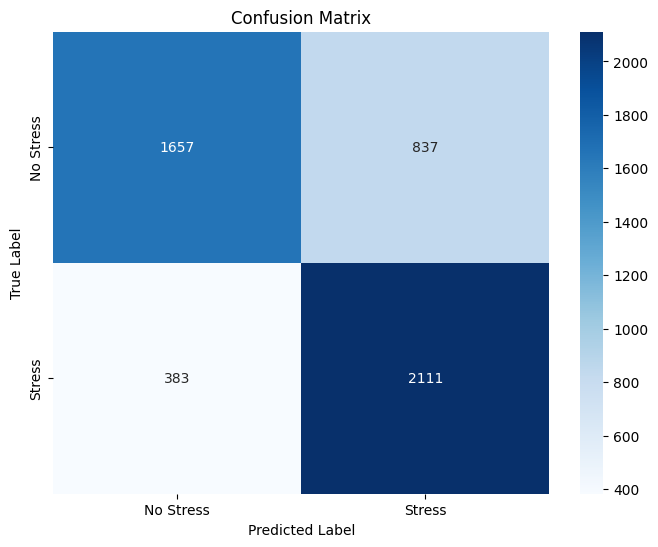

In [92]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix

# Generate predictions on the test set
y_pred_probs = best_model.predict(x_val_resampled, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val_resampled, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Compute metrics
precision = precision_score(y_val_resampled, y_pred)
recall = recall_score(y_val_resampled, y_pred)
accuracy = accuracy_score(y_val_resampled, y_pred)
auc = roc_auc_score(y_val_resampled, y_pred_probs)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"AUC: {auc}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stress', 'Stress'], yticklabels=['No Stress', 'Stress'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('val_model_results.png', dpi = 120)
plt.show()

Confusion Matrix:
[[4244 1612]
 [   1 5855]]
Precision: 0.7841167805008705
Recall: 0.9998292349726776
Accuracy: 0.8622780054644809
AUC: 0.979330039457919


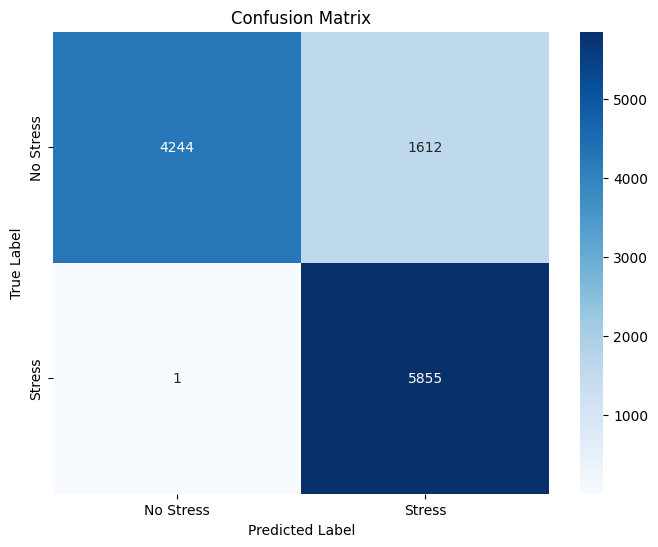

In [93]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix

# Generate predictions on the test set
y_pred_probs = best_model.predict(x_train_resampled, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_train_resampled, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Compute metrics
precision = precision_score(y_train_resampled, y_pred)
recall = recall_score(y_train_resampled, y_pred)
accuracy = accuracy_score(y_train_resampled, y_pred)
auc = roc_auc_score(y_train_resampled, y_pred_probs)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"AUC: {auc}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stress', 'Stress'], yticklabels=['No Stress', 'Stress'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('train_model_results.png', dpi = 120)
plt.show()

Confusion Matrix for S16:
[[444 176]
 [ 12  72]]
Metrics for S16:
Precision: 0.2903225806451613
Recall: 0.8571428571428571
Accuracy: 0.7329545454545454
AUC: 0.8409754224270353
f1-score: 0.43373493975903615


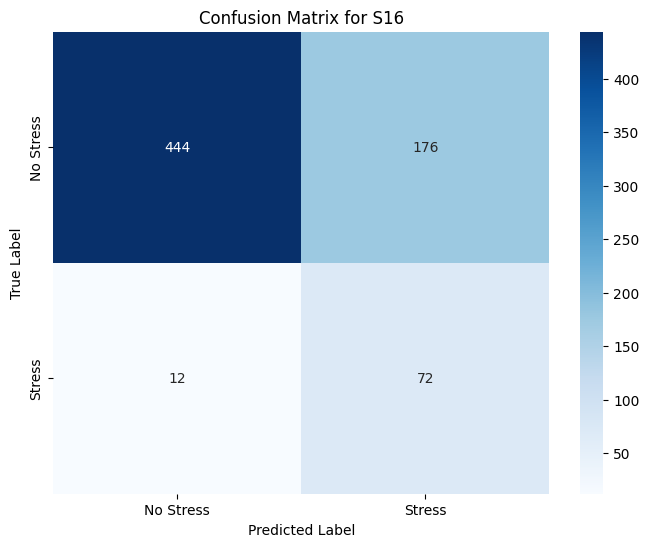

Confusion Matrix for S17:
[[561  89]
 [ 74  16]]
Metrics for S17:
Precision: 0.1523809523809524
Recall: 0.17777777777777778
Accuracy: 0.7797297297297298
AUC: 0.6067350427350428
f1-score: 0.1641025641025641


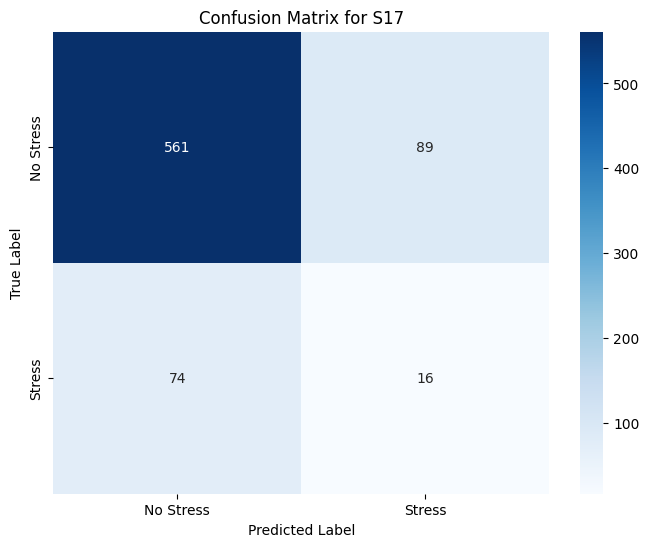

array([[1.39853097e-02],
       [9.80015695e-01],
       [3.50646465e-03],
       [2.77682208e-03],
       [1.47279666e-03],
       [9.72349167e-01],
       [5.08237556e-02],
       [2.48905048e-02],
       [1.06836618e-04],
       [1.94942281e-02],
       [5.56753424e-04],
       [2.08980162e-02],
       [4.98855989e-05],
       [2.98452470e-02],
       [3.07454355e-02],
       [7.16756999e-01],
       [3.98408838e-06],
       [9.61774290e-01],
       [8.43124628e-01],
       [2.21193256e-03],
       [9.97382868e-03],
       [3.85001069e-03],
       [3.22814554e-01],
       [3.79582285e-04],
       [1.12128626e-04],
       [3.17412317e-02],
       [1.34156679e-03],
       [6.34202585e-02],
       [1.75051279e-02],
       [4.80113691e-03],
       [1.06323576e-04],
       [1.26486109e-03],
       [4.01083708e-01],
       [2.51917653e-02],
       [1.28531814e-04],
       [9.72269297e-01],
       [2.19907835e-02],
       [1.96094089e-03],
       [3.70324822e-03],
       [9.54086520e-03],


In [94]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(best_model, x_val, y_val, subject_label):
    # Generate predictions on the validation set
    y_pred_probs = best_model.predict(x_val, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred)
    print(f"Confusion Matrix for {subject_label}:")
    print(conf_matrix)

    # Compute metrics
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_probs)
    f1 = f1_score(y_val, y_pred)

    print(f"Metrics for {subject_label}:")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}")
    print(f"f1-score: {f1}")

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stress', 'Stress'], yticklabels=['No Stress', 'Stress'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {subject_label}')
    plt.savefig(f'model_results_{subject_label}.png', dpi=120)
    plt.show()

    return y_pred_probs

# Evaluate for subject S16
y_pred_probs = evaluate_model(best_model, x_test_subject_1_padded, y_test_subject_1, 'S16')

# Evaluate for subject S17
evaluate_model(best_model, x_test_subject_2_padded, y_test_subject_2, 'S17')




Plotting signals with label 0:


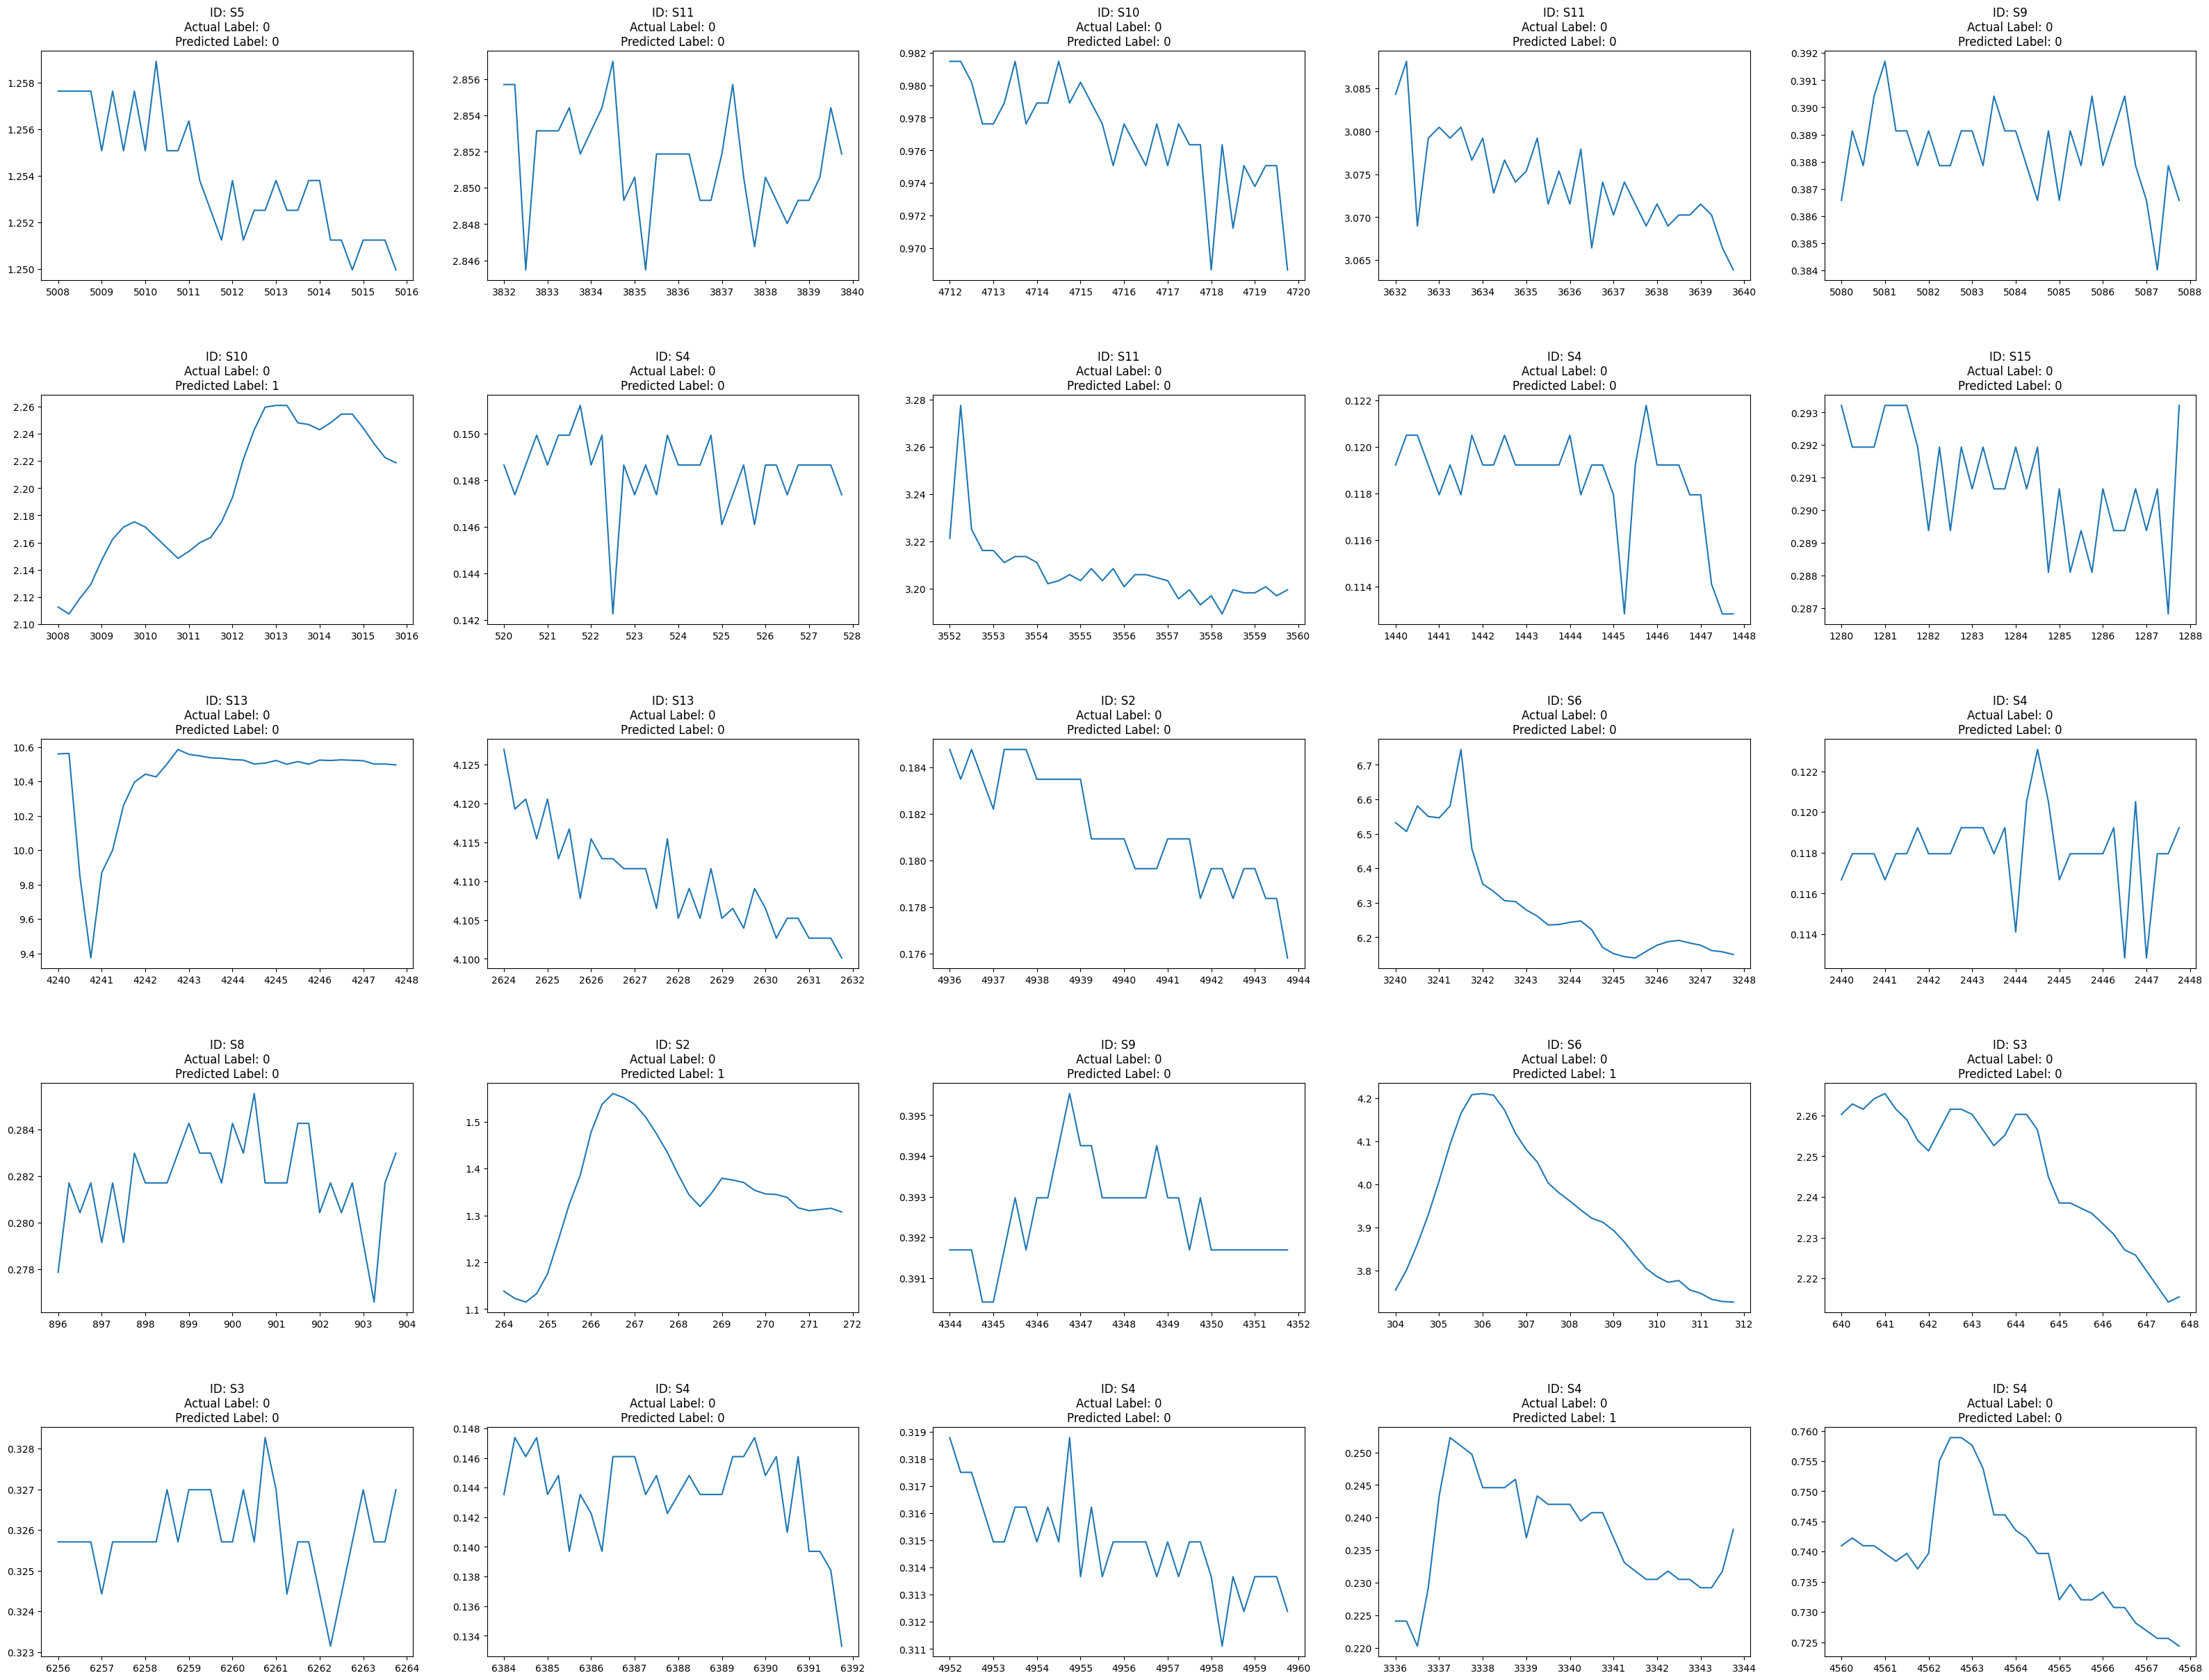

Plotting signals with label 1:


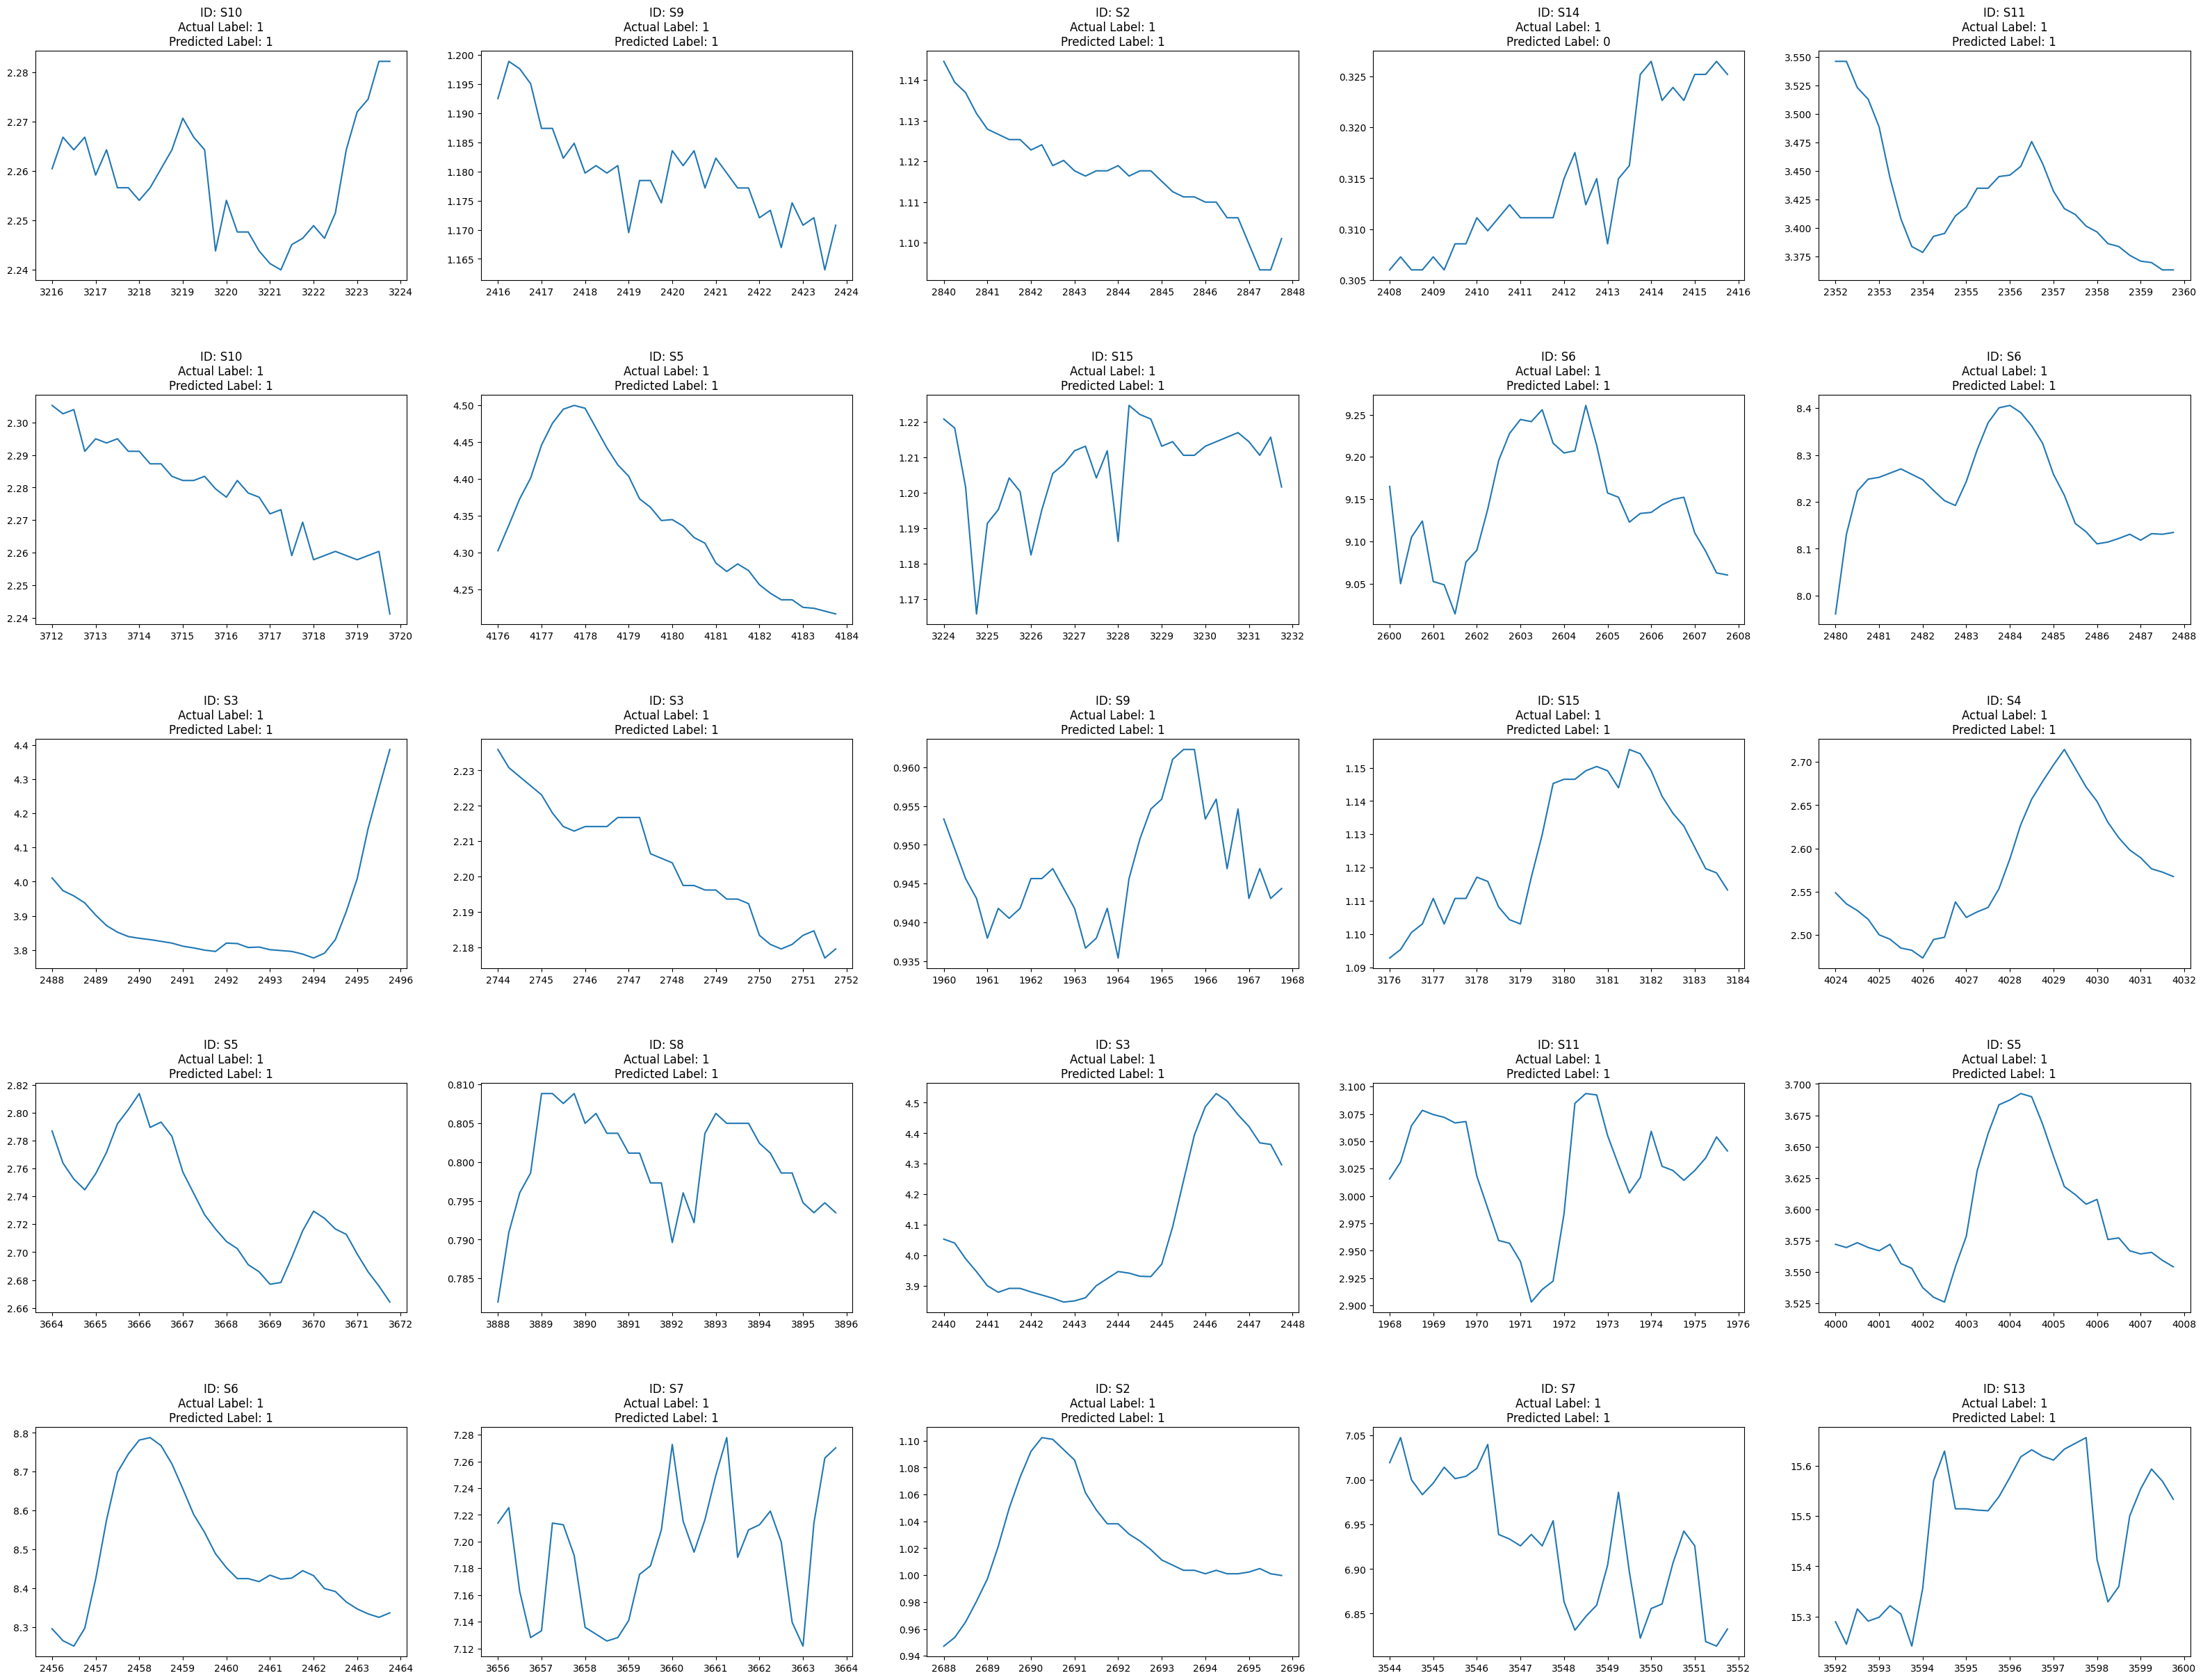

In [95]:
import numpy as np
import matplotlib.pyplot as plt

scaler = MinMaxScaler()

def view_evaluated_eeg_plots(model, sequences_df, scaler):
    def plot_signals(data, labels, predictions, ids, times):
        total_plots = len(data)
        cols = total_plots // 5
        rows = total_plots // cols
        if total_plots % cols != 0:
            rows += 1
        pos = range(1, total_plots + 1)
        fig = plt.figure(figsize=(40, 30))
        for i, (plot_data, og_label, pred_label, id_, time) in enumerate(zip(data, labels, predictions, ids, times)):
            plt.subplot(rows, cols, pos[i])
            plt.plot(time, plot_data)
            plt.title(f"ID: {id_}\nActual Label: {og_label}\nPredicted Label: {pred_label}")
            fig.subplots_adjust(hspace=0.5)
        plt.show()

    def generate_signals_for_label(label, num_signals=25):
        filtered_df = sequences_df[sequences_df['downsampled_label'] == label]
        sampled_df = filtered_df.sample(n=num_signals, random_state=42)
        data = sampled_df['w_eda']
        times = sampled_df['Time']
        data_array = [scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in data]
        data_array = np.asarray(data_array).astype(np.float32).reshape(-1, 32, 1)
        labels = sampled_df['downsampled_label'].tolist()
        ids = sampled_df['ID'].tolist()  # Extract IDs
        predictions = (model.predict(data_array, verbose=0) > 0.5).astype(int).flatten()
        return data, labels, predictions, ids, times

    data_0, labels_0, predictions_0, ids_0, times_0 = generate_signals_for_label(0)
    data_1, labels_1, predictions_1, ids_1, times_1 = generate_signals_for_label(1)
    
    print("Plotting signals with label 0:")
    plot_signals(data_0, labels_0, predictions_0, ids_0, times_0)
    
    print("Plotting signals with label 1:")
    plot_signals(data_1, labels_1, predictions_1, ids_1, times_1)

# Call the function with the required arguments
view_evaluated_eeg_plots(best_model, sequences_df, scaler)


In [96]:
# import numpy as np
# import matplotlib.pyplot as plt

# def view_evaluated_eeg_plots(model, sequences_df, scaler, target_id):
#     def plot_signals(data, labels, predictions, ids, times):
#         total_plots = len(data)
#         cols = total_plots // 5
#         rows = total_plots // cols
#         if total_plots % cols != 0:
#             rows += 1
#         fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3))
#         for i, (plot_data, og_label, pred_label, id_, time) in enumerate(zip(data, labels, predictions, ids, times)):
#             if len(plot_data) == 0:  # Skip empty plots
#                 continue
#             ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
#             color = 'green' if og_label == pred_label else 'red'
#             ax.plot(time, plot_data, color=color)
#             ax.set_title(f"ID: {id_}\nActual Label: {og_label}\nPredicted Label: {pred_label}")
#             ax.set_xlabel('Time')
#             ax.set_ylabel('Data')
#         plt.tight_layout()
#         plt.show()

#     def generate_signals_for_id(target_id):
#         filtered_df = sequences_df[sequences_df['ID'] == target_id]
#         filtered_df = filtered_df.sort_values(by='Time')  # Sort by time
#         data = filtered_df['w_eda']
#         times = filtered_df['Time']
#         data_array = [scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in data]
#         data_array = np.asarray(data_array).astype(np.float32).reshape(-1, 32, 1)
#         labels = filtered_df['downsampled_label'].tolist()
#         ids = filtered_df['ID'].tolist()  # Extract IDs
#         predictions = (model.predict(data_array, verbose=0) > 0.5).astype(int).flatten()
#         return data, labels, predictions, ids, times

#     data, labels, predictions, ids, times = generate_signals_for_id(target_id)
    
#     print(f"Plotting signals for ID: {target_id}")
#     plot_signals(data, labels, predictions, ids, times)

#     # Create confusion matrix
#     cm = confusion_matrix(labels, predictions)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('Actual Label')
#     plt.title('Confusion Matrix')
#     plt.show()

# Call the function with the required arguments
# view_evaluated_eeg_plots(best_model, sequences_df_balanced, scaler, target_id='S2')
